In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Quiz 1

**Q1:** Age + Years at current employer + Years at current address + Income over the past year - Current credit card debt - Current automobile debt

**Q2:**

In [33]:
train = pd.read_csv('train_final.csv', header=None)

In [35]:
train.columns = ['id', 'age', 'employ', 'address', 'income', 'ccdebt', 'cardebt', 'label']

In [36]:
train['score'] = - train['age'] - train['employ'] + train['address'] - train['income'] - train['ccdebt'] - train['cardebt']

In [37]:
train = train.sort_values(by='score', ascending=False).reset_index(drop=True)

In [6]:
pos_count = (train['label'] == 1).sum()
neg_count = (train['label'] == 0).sum()
pos_count, neg_count

(50, 150)

In [7]:
sorted_labels = list(train.sort_values(by='score', ascending=False)['label'])

In [8]:
pos_true = 0
pos_false = 0
tpr = []
fpr = []
for index, label in enumerate(sorted_labels):
    if label == 1:
        pos_true += 1
    else:
        pos_false += 1
    tpr.append(pos_true/pos_count)
    fpr.append(pos_false/neg_count)

(0, 0.05)

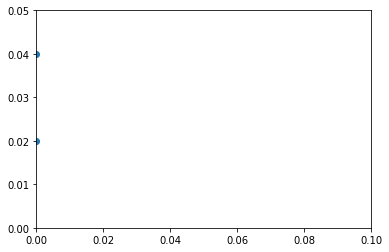

In [9]:
plt.scatter(fpr, tpr)
plt.xlim([0, 0.1])
plt.ylim([0, 0.05])

In [10]:
auc = sum(pd.Series(fpr).diff(1).fillna(0) * pd.Series(tpr))
auc

0.7814666666666673

In [11]:
roc_auc_score(train['label'], train['score'])

0.7814666666666666

**Q3:**

In [12]:
def score(df):
    df = df.copy()
    df['score'] = - df['age'] - df['employ'] + df['address'] - df['income'] - df['ccdebt'] - df['cardebt']
    return df.sort_values(by='score', ascending=False).reset_index(drop=True)

In [13]:
def count_pos(df):
    sorted_labels = list(df.sort_values(by='score', ascending=False)['label'])
    pos_true_count = 0
    pos_false_count = 0
    pos_true_counts = []
    pos_false_counts = []
    for index, label in enumerate(sorted_labels):
        if label == 1:
            pos_true_count += 1
        else:
            pos_false_count += 1
        pos_true_counts.append(pos_true_count)
        pos_false_counts.append(pos_false_count)
    return pos_true_counts, pos_false_counts

In [14]:
def calculate_auc(df):
    pos_count = (df['label'] == 1).sum()
    neg_count = (df['label'] == 0).sum()
    tpc, fpc = count_pos(df)
    tpr = [count / pos_count for count in tpc]
    fpr = [count / neg_count for count in fpc]
    auc = sum(pd.Series(fpr).diff(1).fillna(0) * pd.Series(tpr))
    return auc

In [15]:
test = pd.read_csv('test_final.csv', header=None)

In [16]:
test.columns = ['id', 'age', 'employ', 'address', 'income', 'ccdebt', 'cardebt', 'label']

In [17]:
test = score(test)

In [18]:
calculate_auc(test)

0.7766666666666666

**Q4:** Find cost minimizing threshold

In [19]:
fn_cost = 5000
fp_cost = 2500
pos_total = (train['label'] == 1).sum()

In [93]:
def calculate_cost(df, fn_cost=5000, fp_cost=2500):
    pos_total = (df['label'] == 1).sum()
    tpc, fpc = count_pos(df)
    fnc = pos_total - pd.Series(tpc)
    fpc = pd.Series(fpc)
    cost_df = pd.concat([fnc, fpc, df['score'], df['label']], axis=1)
    cost_df.columns = ['fn', 'fp', 'score', 'label']
    cost_df['fn_cost'] = cost_df['fn'] * fn_cost
    cost_df['fp_cost'] = cost_df['fp'] * fp_cost
    cost_df['total_cost'] = cost_df['fn_cost'] + cost_df['fp_cost']
    return cost_df

In [94]:
train_cost = calculate_cost(train)

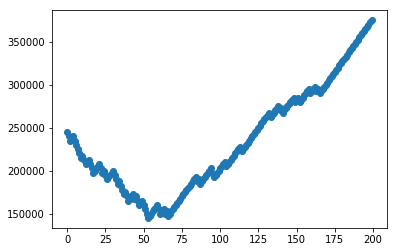

In [95]:
plt.scatter(x=range(len(train_cost)), y=train_cost['total_cost'])

In [63]:
train_threshold = train_cost.loc[train_cost.idxmin()['total_cost']]
train_threshold['score']

1.3092582415882994

**Q5:** Find cost per event for threshold

In [24]:
train_threshold['total_cost'] / len(train)

725.0

**Q6:** Use train threshold to predict labels for test set

In [25]:
test['pred'] = (test['score'] > train_threshold['score']).astype(int)
test

,id,age,employ,address,income,ccdebt,cardebt,label,score,pred
0,246,-0.963905,-0.842530,1.872879,-0.117654,-2.096558,-0.307024,1,6.200550,1
1,220,-1.291959,-0.429934,0.657363,-0.047444,-2.172531,-0.686444,1,5.285674,1
2,339,-0.737364,-0.509756,1.045394,0.786969,-0.779929,-2.323567,1,4.609041,1
3,373,-1.053619,-1.177311,2.370474,-0.788595,0.551223,0.335295,1,4.503481,1
4,381,-0.941804,-1.236030,1.826402,-0.847735,0.435095,0.096392,1,4.320484,1
5,244,1.707522,0.934898,-0.630013,4.857578,-6.781217,-5.580227,1,4.231434,1
6,232,-0.067112,-0.333885,3.769480,-0.403986,0.649648,-0.296652,0,4.221468,1
7,358,-0.820323,-1.155353,0.184450,-0.526398,-0.368936,-0.996954,1,4.052414,1
8,302,-1.001490,-0.904701,2.476658,-0.611676,0.526525,0.680671,0,3.787328,1
9,393,-0.049167,-1.033303,1.585776,-0.458126,-0.603614,0.101689,1,3.628296,1


In [26]:
test_fnc = ((test['label'] == 1) & (test['pred'] == 0)).sum()
test_fpc = ((test['label'] == 0) & (test['pred'] == 1)).sum()

In [27]:
test_total_cost = test_fnc * fn_cost + test_fpc * fp_cost
test_cost_per_event = test_total_cost / len(test)
test_cost_per_event

887.5

**Q7:** Find savings compared to approving all applicants

In [28]:
saving_per_event = 1250 - test_cost_per_event
saving_per_event

362.5

**Q8:** Find payback period (interest-fee)

In [29]:
saving_per_day = saving_per_event * 1000
payback_period = 750000 / saving_per_day
payback_period

2.0689655172413794

**Q9:** Find true positive rate (of test set?)

In [30]:
test_tpr = ((test['label'] == 1) & (test['pred'] == 1)).sum() / (test['label'] == 1).sum()
test_tpr

0.58

**Q10**: Find test incidence (proportion of predicted positives in test set)

In [31]:
test_incidence = (test['pred'] == 1).sum() / len(test)
test_incidence

0.29

# Quiz 2

**Q1**

In [75]:
egger_train = pd.read_csv('egger_train.csv', header=None)
egger_train.columns = ['id', 'score', 'label']

In [46]:
calculate_auc(egger_train)

0.8484000000000014

**Q2**

In [96]:
egger_train_cost = calculate_cost(egger_train)

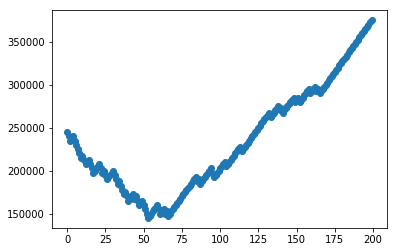

In [97]:
plt.scatter(x=range(len(egger_train_cost)), y=train_cost['total_cost'])

In [98]:
egger_train_threshold = egger_train_cost.loc[egger_train_cost.idxmin()['total_cost']]
egger_train_threshold['score']

2844

In [67]:
egger_train_threshold

fn                11
fp                25
score           2844
label              1
fn_cost        55000
fp_cost        62500
total_cost    117500
Name: 63, dtype: int64

In [71]:
(2844 - egger_train_cost['score'].min()) / (egger_train_cost['score'].max() - egger_train_cost['score'].min())

0.6558020812880424

In [77]:
2844 / egger_train_cost['score'].max()

0.6186643463128128

**Q3**

In [99]:
egger_train_threshold['total_cost'] / len(egger_train_cost)

587.5

**Q4**

In [100]:
egger_test = pd.read_csv('egger_test.csv', header=None)
egger_test.columns = ['id', 'score', 'label']

In [101]:
calculate_auc(egger_test)

0.852666666666667

**Q5**

In [102]:
egger_test['pred'] = (egger_test['score'] > egger_train_threshold['score']).astype(int)
egger_test

,id,score,label,pred
0,201,3032.901421,1,1
1,202,2825.800440,1,0
2,203,322.315761,0,0
3,204,249.832438,0,0
4,205,1066.581297,0,0
5,206,778.965988,0,0
6,207,240.276924,1,0
7,208,1045.702698,1,0
8,209,397.379617,0,0
9,210,-52.408452,0,0


In [103]:
egger_test_fnc = ((egger_test['label'] == 1) & (egger_test['pred'] == 0)).sum()
egger_test_fpc = ((egger_test['label'] == 0) & (egger_test['pred'] == 1)).sum()

In [104]:
egger_test_total_cost = egger_test_fnc * fn_cost + egger_test_fpc * fp_cost
egger_test_cost_per_event = egger_test_total_cost / len(egger_test)
egger_test_cost_per_event

800.0

In [90]:
egger_test_tpr = ((egger_test['label'] == 1) & (egger_test['pred'] == 1)).sum() / (egger_test['label'] == 1).sum()
egger_test_tpr

0.4